# 01 Pre-Processing

## Initialize Environment
First import all the necessary packages here:

In [1]:
# Import necessary packages
import os
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
import scanpy.external as sce
import matplotlib.pyplot as pl
import anndata2ri
import logging

from matplotlib import colors
from datetime import datetime as dt
from scipy.stats import median_abs_deviation

# Scanpy settings
sc.settings.verbosity = 3
sc.logging.print_header()

2025-12-05 19:13:35.022075: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


scanpy==1.9.5 anndata==0.10.2 umap==0.5.4 numpy==1.24.4 scipy==1.11.3 pandas==2.1.1 scikit-learn==1.3.1 statsmodels==0.14.0 igraph==0.11.2 louvain==0.8.1 pynndescent==0.5.10


Identify the starting directory. Get a timestamp for the run. From the timestamp, derive the resulting output h5ad filename.

In [2]:
# Name Variables and Settings
fn = "01_"                              # Filename Prefix
sf = "_preprocessing"                   # Filename Suffix
experiment = "Runx3-mut"                # Experiment batch
savedata = True                         # Save data at the end

# Set working directory
os.chdir("/home/dalbao/2023-012-Runx3mutD8scRNA/AlbaoRunx3Manuscript/single_cell/01_preprocessing")

# Determine work location
print("The work location for this notebook is: " + os.getcwd() + "\n")

# Get a timestamp for the start of the run
timestamp = dt.now()
print("This notebook was last run on " + timestamp.strftime("%y-%m-%d %H:%M"))

# Determine the filename for the expected output h5ad
fn = fn + timestamp.strftime("%y-%m-%d-%H-%M")
print("The filename for the AnnData output of this notebook will be:")
print(fn + sf + "_{RPE|MRE}.h5ad")
print("which will be saved in the WORKDIR/h5ad/ folder.")

The work location for this notebook is: /blue/m.pipkin/dalbao/2023-012-Runx3mutD8scRNA/AlbaoRunx3Manuscript/single_cell/01_preprocessing

This notebook was last run on 25-12-05 19:13
The filename for the AnnData output of this notebook will be:
01_25-12-05-19-13_preprocessing_{RPE|MRE}.h5ad
which will be saved in the WORKDIR/h5ad/ folder.


The work directory is structured to contain a folder named "outs" which itself contains output from the Cell Ranger multi pipeline. "outs" contains demultiplexed data.

In [3]:
sd_pre= "../../source_data/gem"
sd_post = "/outs/per_sample_outs"

# Path to look inside
target_dir = sd_pre + "1" + sd_post

# List **only folders**
sample_names = [
    d for d in os.listdir(target_dir)
    if os.path.isdir(os.path.join(target_dir, d))
]
sample_names.sort()
print(sample_names)

['Base', 'Naive', 'Null', 'WT', 'd5', 'd8', 'dAD', 'dID', 'dVWRPY']


Go through all the samples in sample_names and then load the data into a new object in Python. This differs from the tutorial in that the different samples which were multiplexed will be loaded and initially pre-processed seprately before concatenating them and performing normalization.

Make one list per GEM.

In [4]:
samples1 = [] # Array to contain the AnnData for each of the individual groups
samples2 = [] # Array to contain the AnnData for each of the individual groups

### MANUAL ANNOTATION
infection = ["Arm", "Naive", "Arm", "Arm", "Arm", "Arm", "Arm", "Arm", "Arm"]
timepoint = ["Day 8", "Naive", "Day 8", "Day 8", "Day 5", "Day 8", "Day 8", "Day 8", "Day 8"]

# Loop through all samples in sample_names for sample1
for index in range(0, len(sample_names)):
    
    # Load samples individually into each array element
    samples1.append(sc.read_10x_mtx(sd_pre +
                                    "1" + 
                                    sd_post +
                                    "/" + 
                                    sample_names[index] + 
                                    "/count/sample_filtered_feature_bc_matrix"))

    # Annotate each sample with the experiment as a group observation
    samples1[index].obs["experiment"] = experiment
    # Annotate each sample with the sample name as a group observation
    samples1[index].obs["group"] = sample_names[index]
    # Annotate each sample with the timepoint as a group observation
    samples1[index].obs["timepoint"] = infection[index]
    # Annotate each sample with the infection as a group observation
    samples1[index].obs["infection"] = timepoint[index]
    # Check output
    samples1[index]
# End loop

del(index) # Cleanup

# Loop through all samples in sample_names for sample1
for index in range(0, len(sample_names)):
    
    # Load samples individually into each array element
    samples2.append(sc.read_10x_mtx(sd_pre +
                                    "2" + 
                                    sd_post + 
                                    "/" + 
                                    sample_names[index] + 
                                    "/count/sample_filtered_feature_bc_matrix"))

    # Annotate each sample with the experiment as a group observation
    samples2[index].obs["experiment"] = experiment
    # Annotate each sample with the sample name as a group observation
    samples2[index].obs["group"] = sample_names[index]
    # Annotate each sample with the timepoint as a group observation
    samples2[index].obs["timepoint"] = infection[index]
    # Annotate each sample with the infection as a group observation
    samples2[index].obs["infection"] = timepoint[index]
    # Check output
    samples2[index]
# End loop

del(index) # Cleanup

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading fr

Then combine all hashtagged samples into one adata file per GEM:

In [5]:
# Set the first element in the array as the base
adata1 = samples1[0]

# Concatenate sample on top of the base
# Start from sample 1, since adata already contains sample 0 
for index in range(1, len(sample_names)):
    adata1 = ad.concat([adata1, samples1[index]], join = "outer") # Outer option does a union of all genes
# End loop

# Confirm resulting AnnData file then cleanup
print(adata1)
del(samples1, index)

# Set the first element in the array as the base
adata2 = samples2[0]

# Concatenate sample on top of the base
# Start from sample 1, since adata already contains sample 0 
for index in range(1, len(sample_names)):
    adata2 = ad.concat([adata2, samples2[index]], join = "outer") # Outer option does a union of all genes
# End loop

# Confirm resulting AnnData file then cleanup
print(adata2)
del(samples2, index)

AnnData object with n_obs × n_vars = 17425 × 32285
    obs: 'experiment', 'group', 'timepoint', 'infection'
AnnData object with n_obs × n_vars = 17704 × 32285
    obs: 'experiment', 'group', 'timepoint', 'infection'


In [6]:
# Make cell_id column
adata1.obs['cell_id'] = adata1.obs.index.astype(str)
adata2.obs['cell_id'] = adata2.obs.index.astype(str)

## Basic pre-processing

For basic quality control metrics, plot the highest expressed genes per sample:

normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


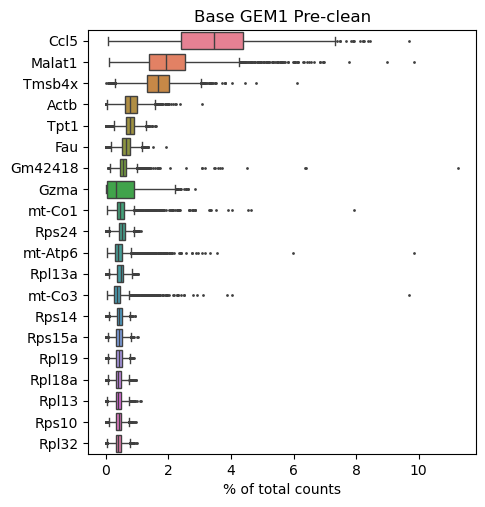

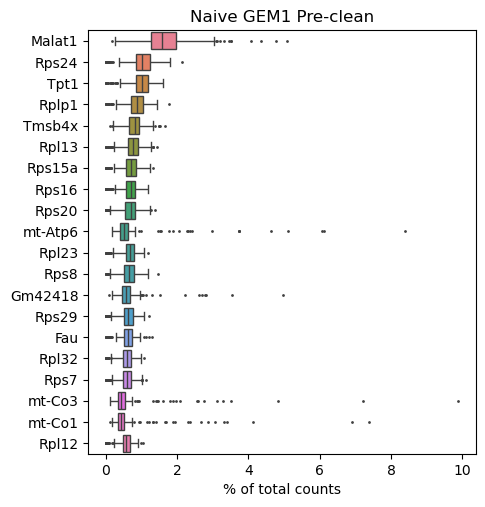

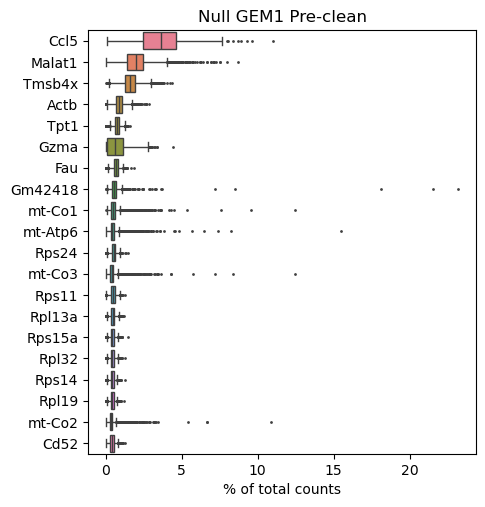

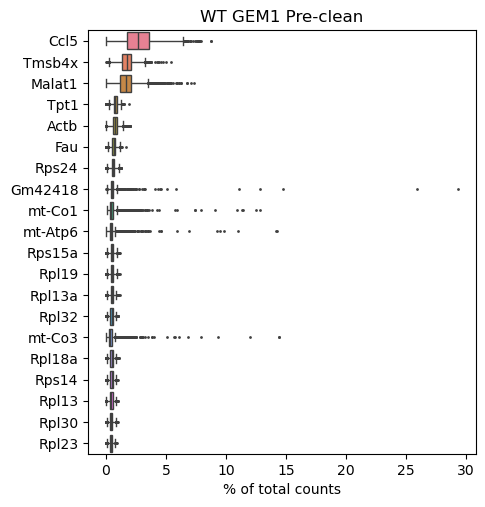

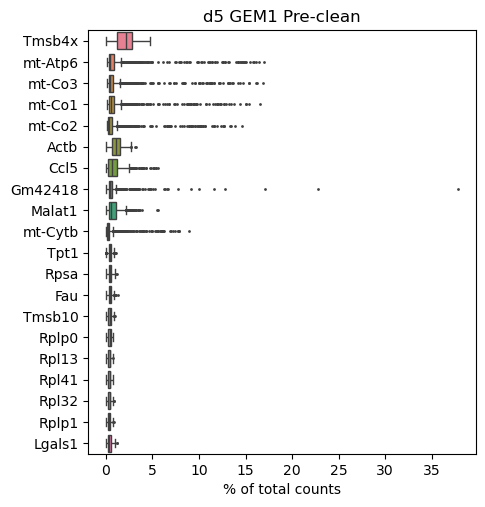

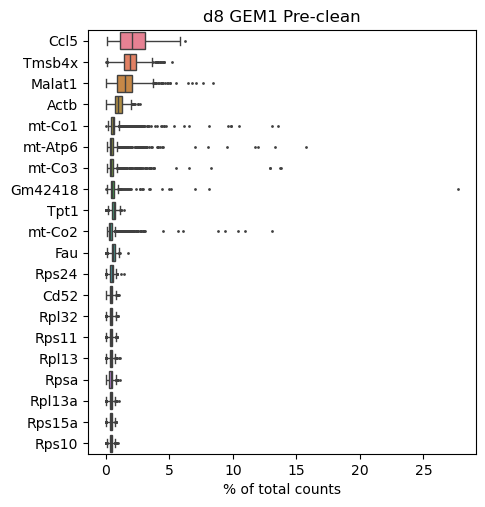

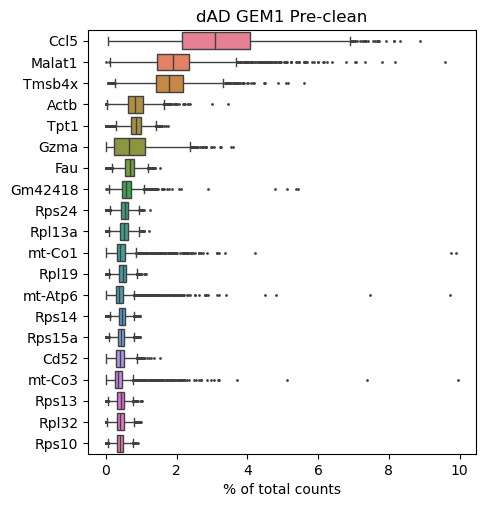

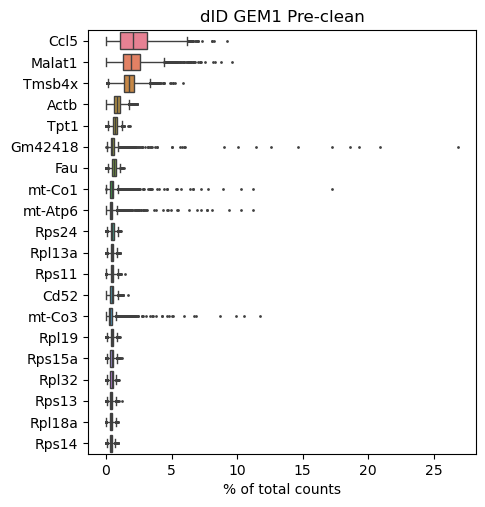

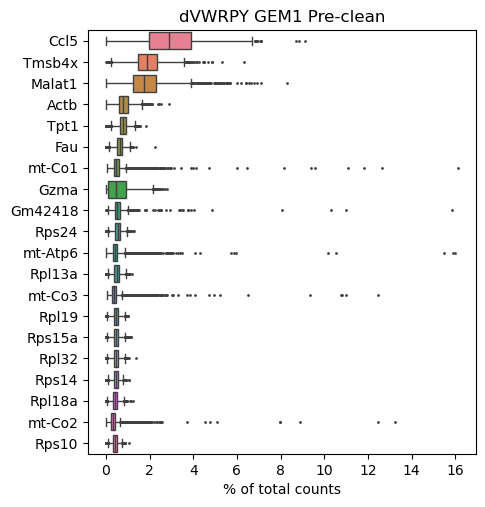

In [7]:
# adata1
# Plot highest expressed genes per sample
for group in sample_names:
    
    plot = sc.pl.highest_expr_genes(adata1[adata1.obs.group == group, :], n_top=20, show = False)
    plot.set_title(group + " GEM1 Pre-clean")
# End of loop

del(plot) # Cleanup``

normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


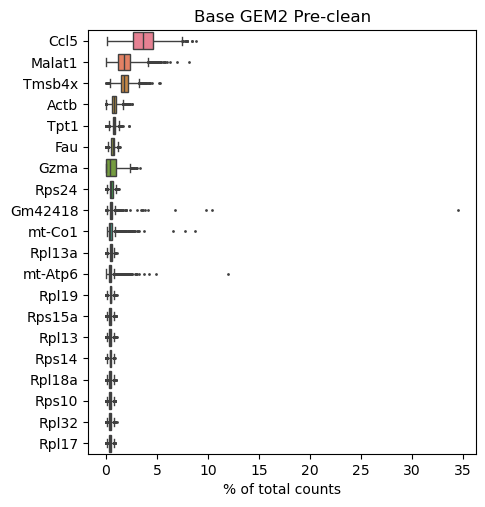

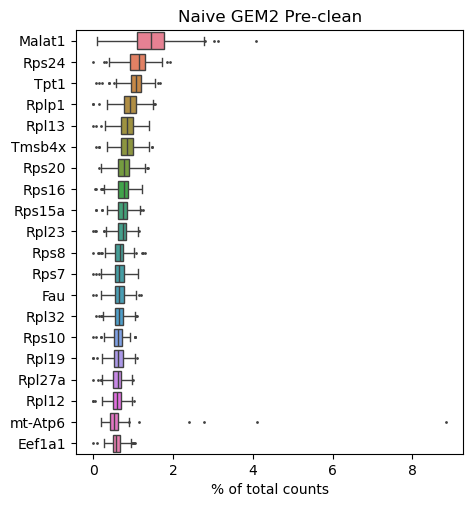

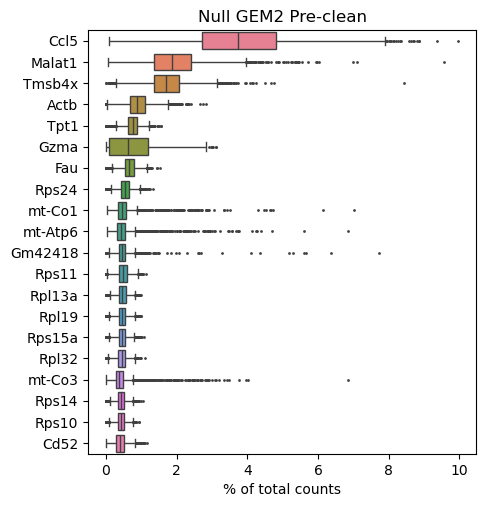

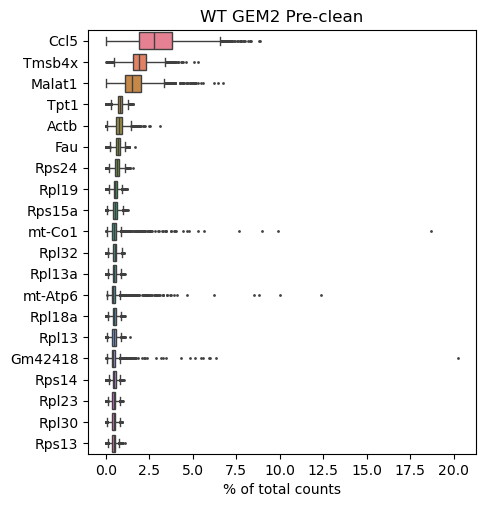

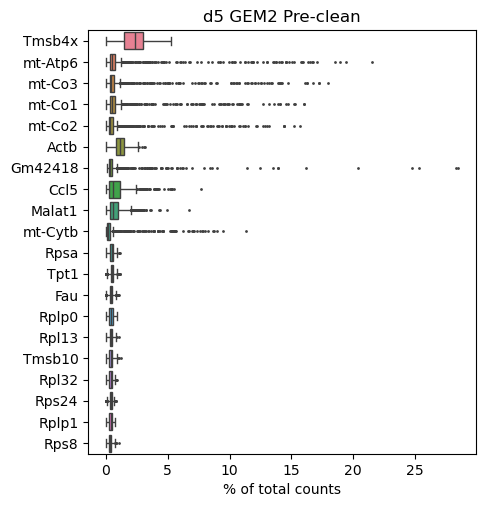

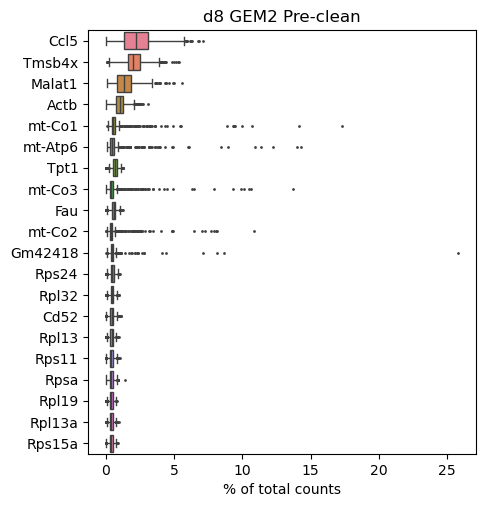

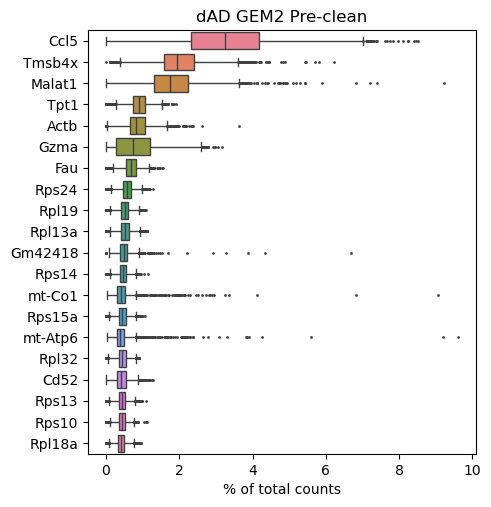

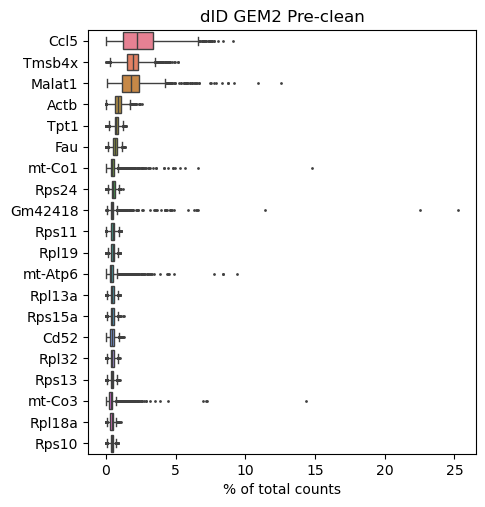

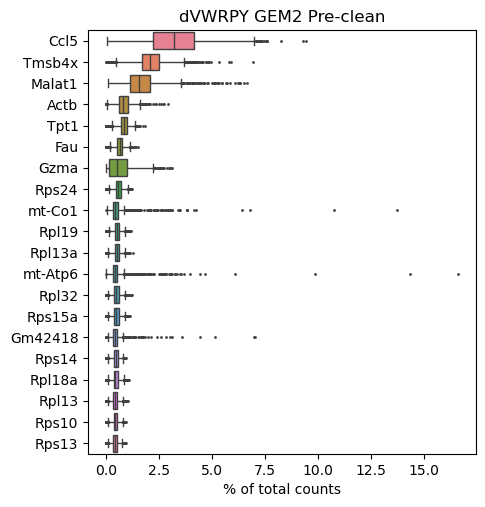

In [8]:
# adata2
# Plot highest expressed genes per sample
for group in sample_names:
    
    plot = sc.pl.highest_expr_genes(adata2[adata2.obs.group == group, :], n_top=20, show = False)
    plot.set_title(group  + " GEM2 Pre-clean")
# End of loop

del(plot) # Cleanup

## Filtering

Create filters for outliers based on counts and number of genes expressed and filter genes based on number of cells or counts.

But first, check the original metric

In [9]:
print(adata1)
print(adata2)

AnnData object with n_obs × n_vars = 17425 × 32285
    obs: 'experiment', 'group', 'timepoint', 'infection', 'cell_id'
AnnData object with n_obs × n_vars = 17704 × 32285
    obs: 'experiment', 'group', 'timepoint', 'infection', 'cell_id'


Compute quality metrics:

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legen

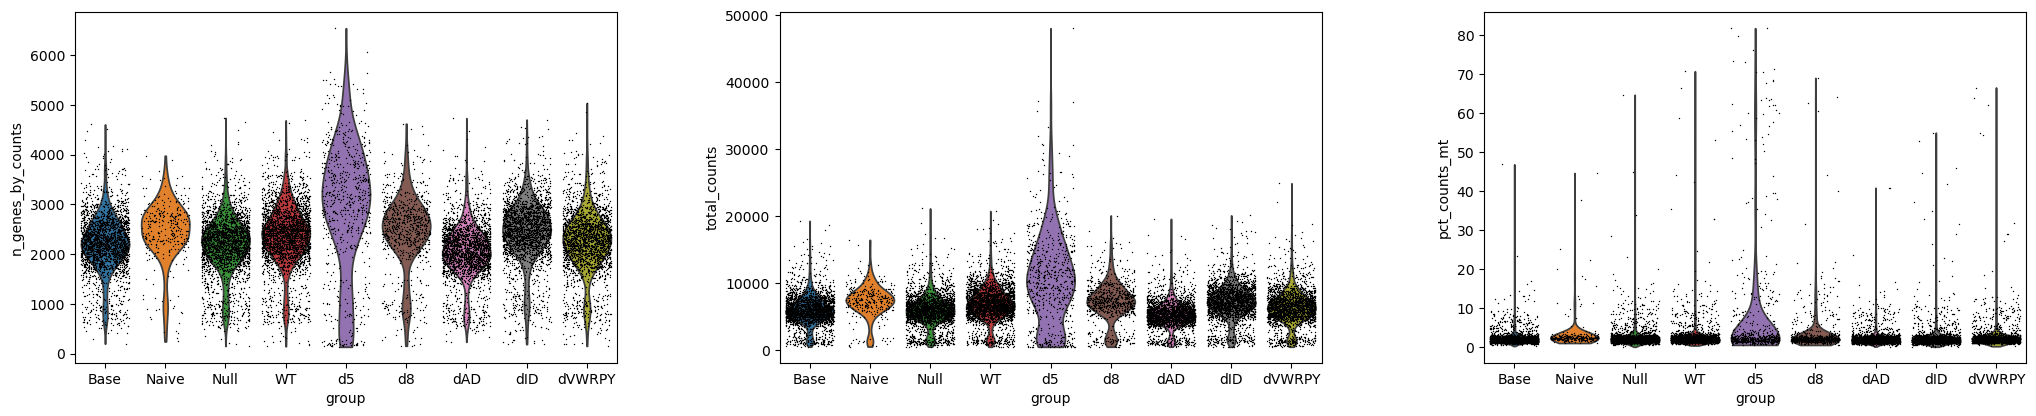

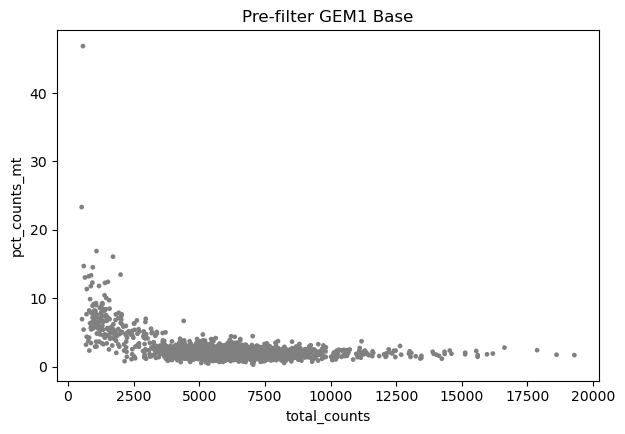

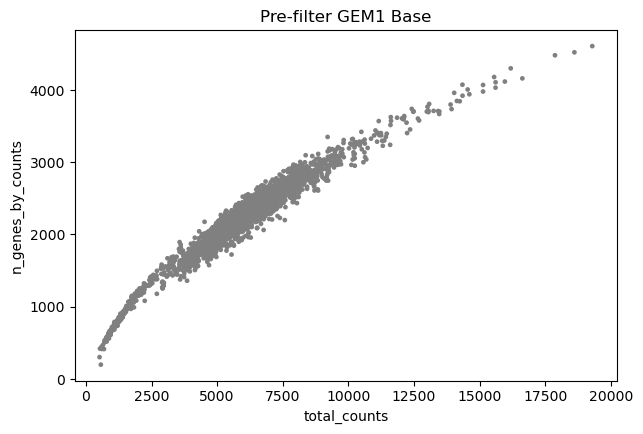

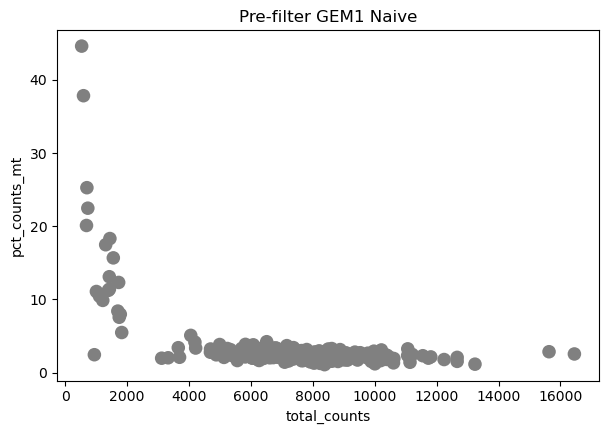

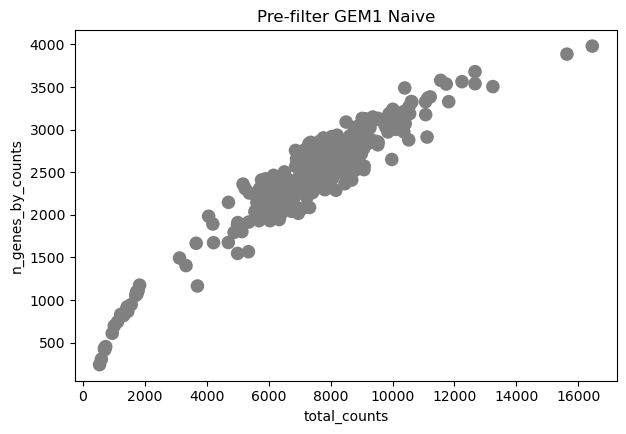

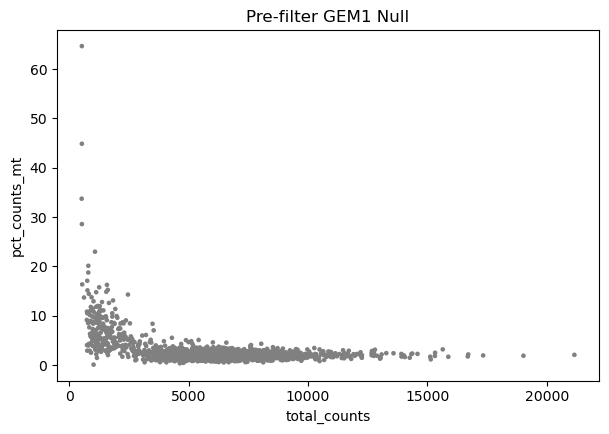

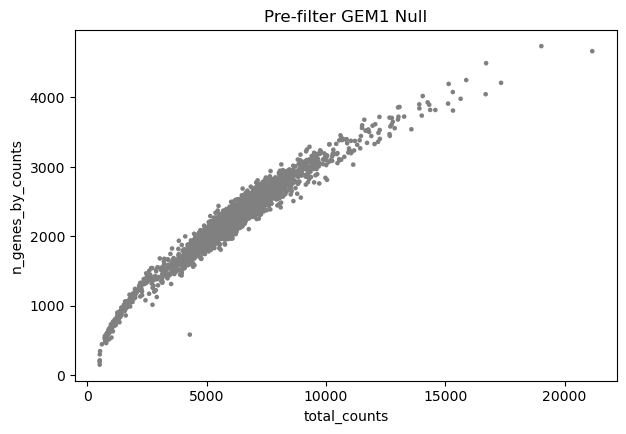

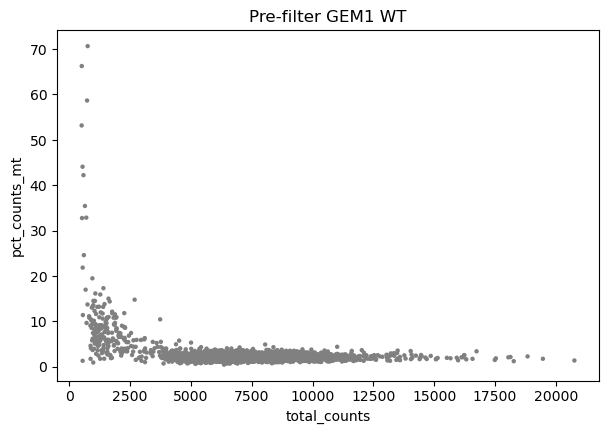

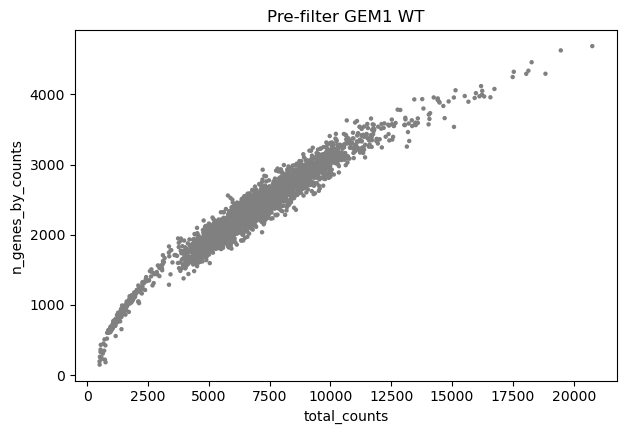

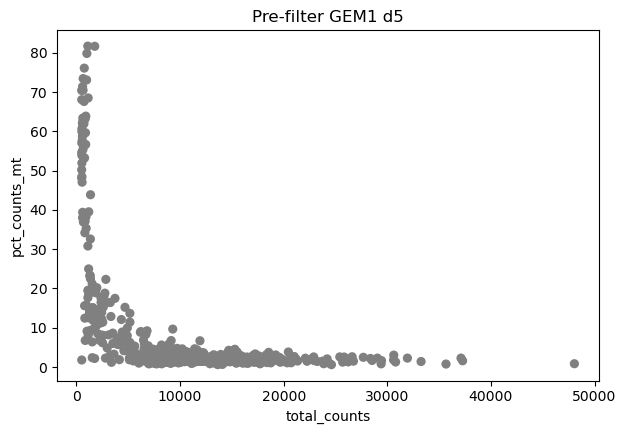

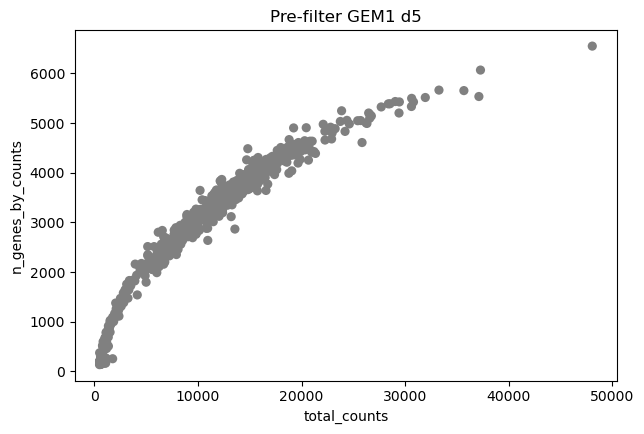

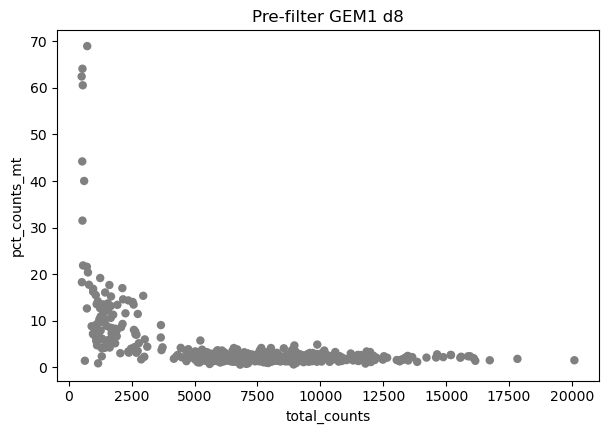

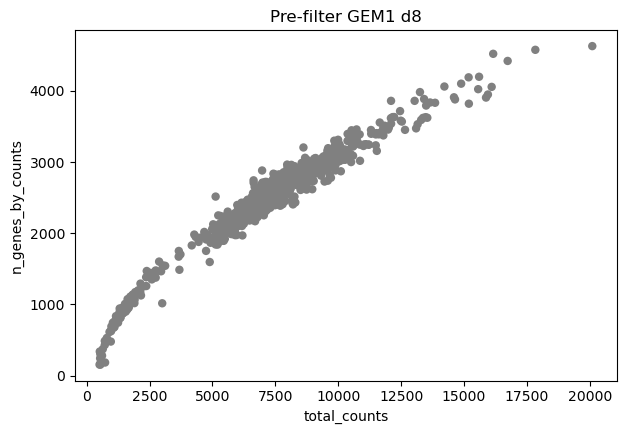

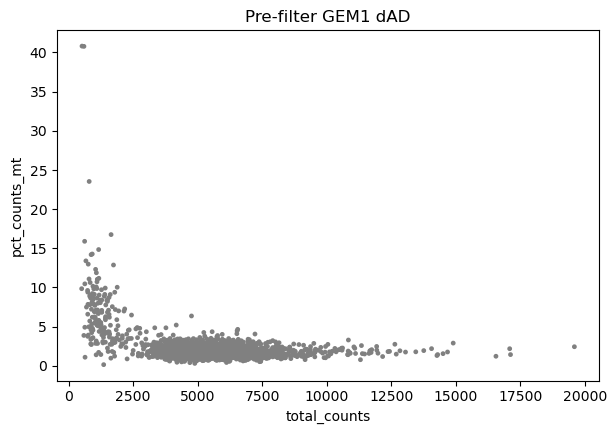

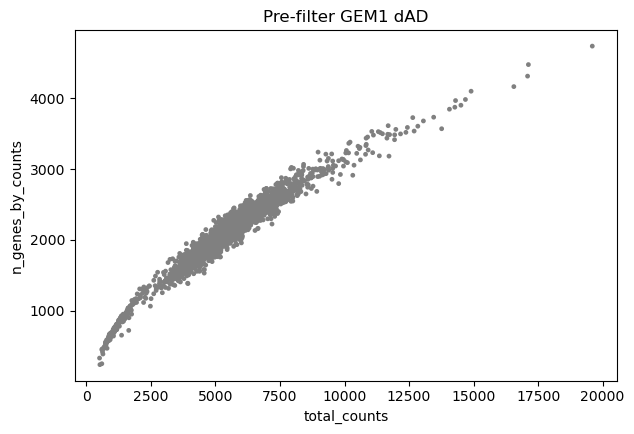

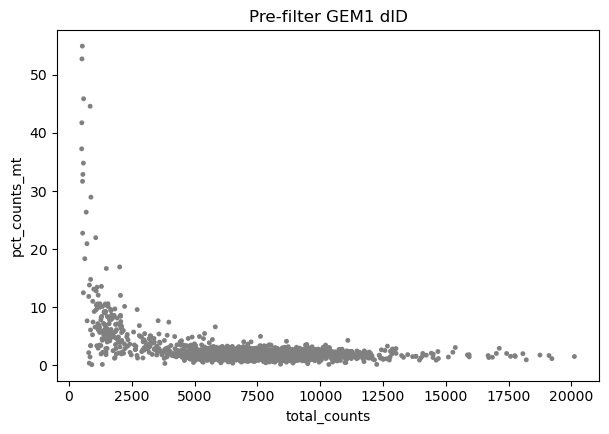

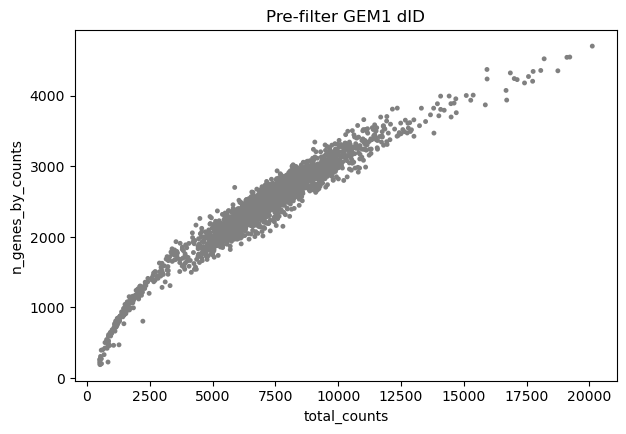

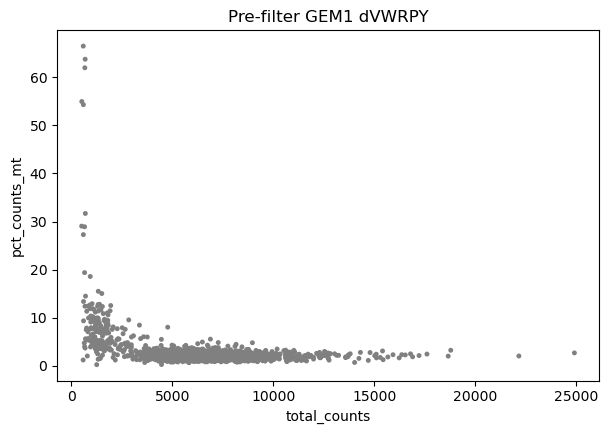

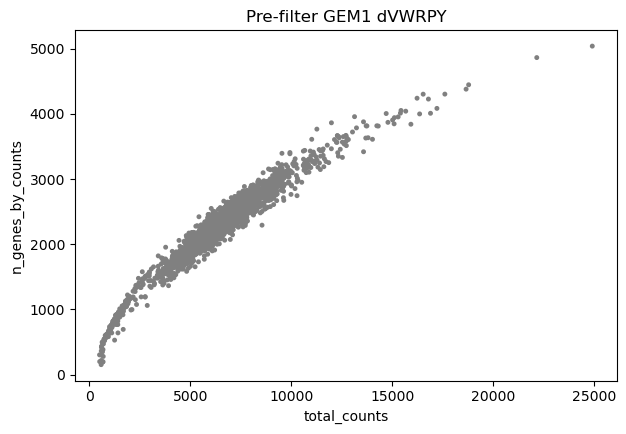

In [10]:
# adata1
# Mitochondrial genes
adata1.var["mt"] = adata1.var_names.str.startswith("mt-")
# Ribosomal genes
adata1.var["ribo"] = adata1.var_names.str.startswith(("Rps", "Rpl"))

# Calculate percent mitochondrial gene contamination
sc.pp.calculate_qc_metrics(adata1, qc_vars=['mt', 'ribo'], percent_top=None, log1p=True, inplace=True)

# Plot quality metrics:

sc.pl.violin(adata1, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby= "group", jitter=0.4, multi_panel=True)
for group in sample_names:
    
    sc.pl.scatter(adata1[adata1.obs.group == group, :], x='total_counts', y='pct_counts_mt', title = "Pre-filter GEM1 "+group)
    sc.pl.scatter(adata1[adata1.obs.group == group, :], x='total_counts', y='n_genes_by_counts', title = "Pre-filter GEM1 "+group)
# End of loop

del(group) # Cleanup

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legen

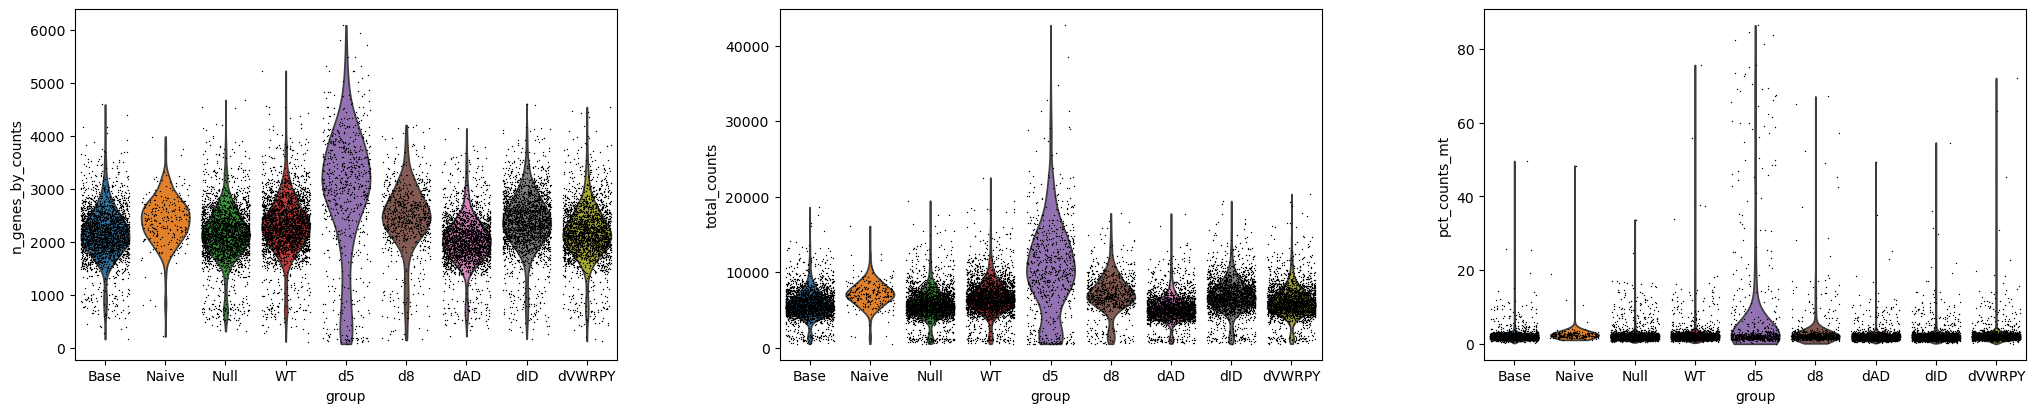

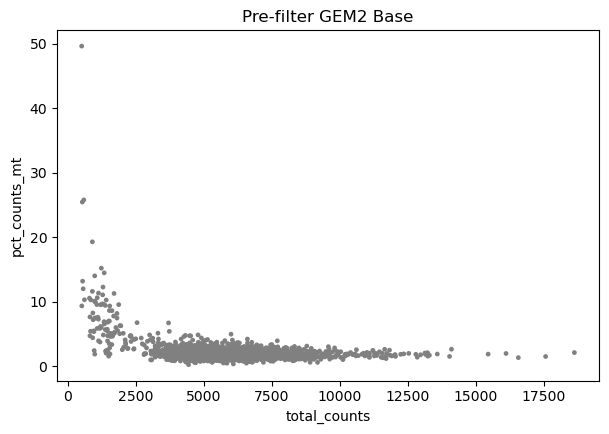

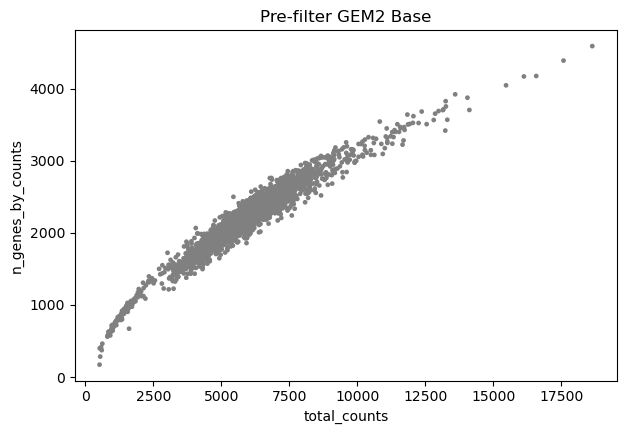

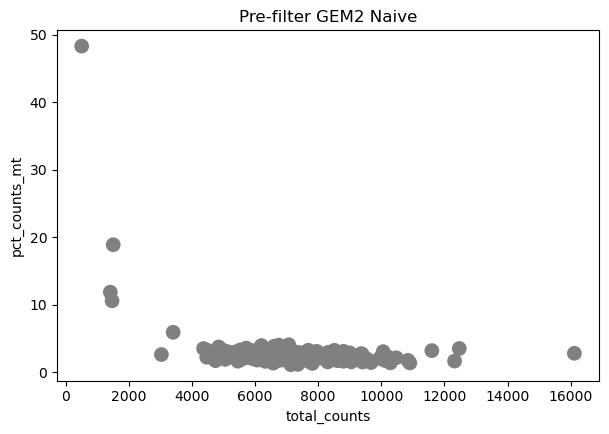

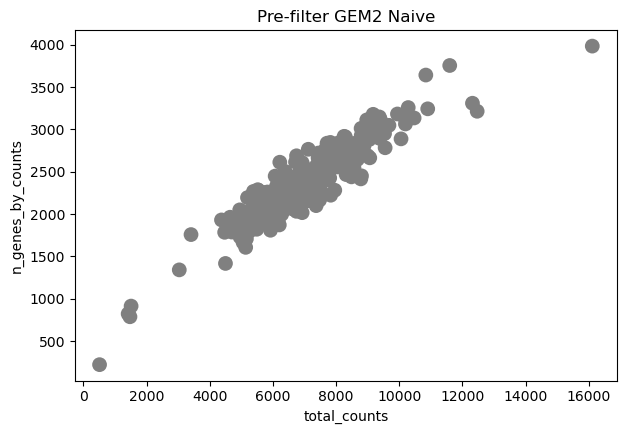

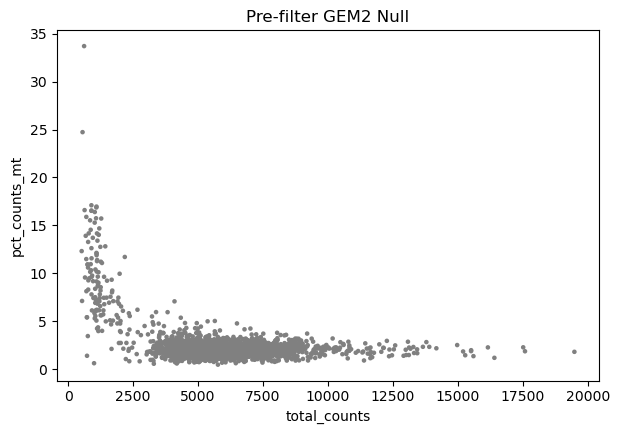

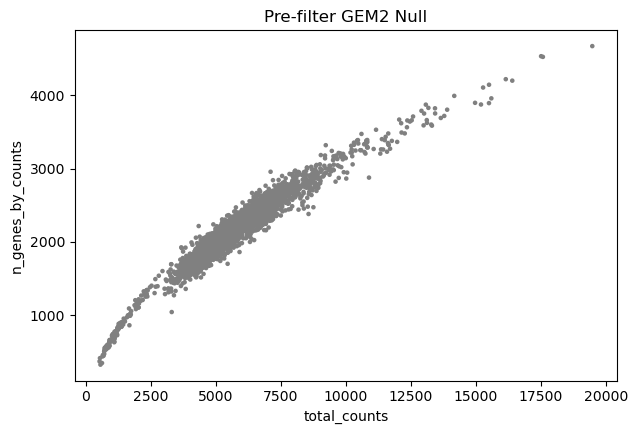

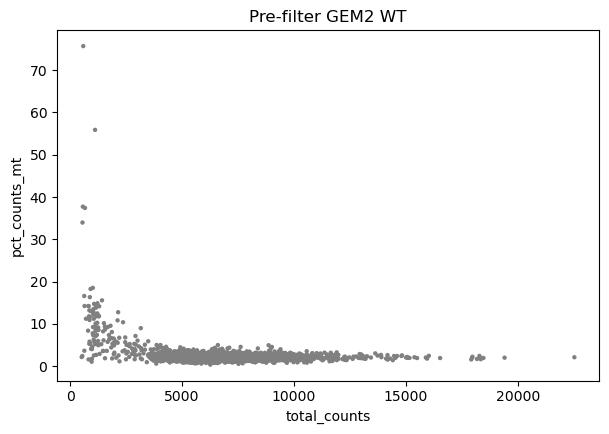

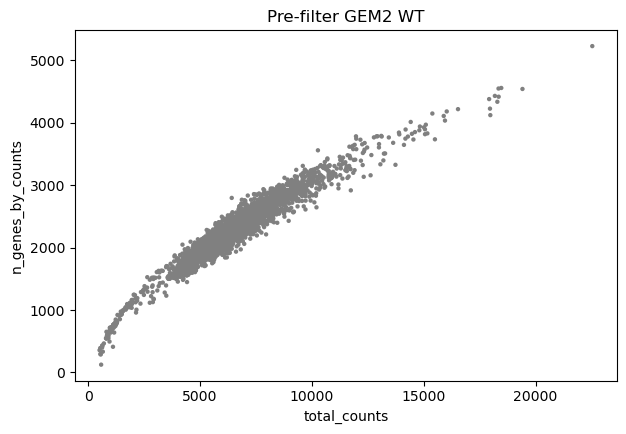

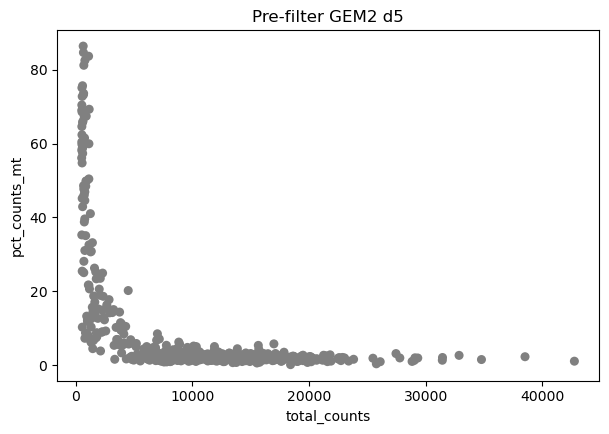

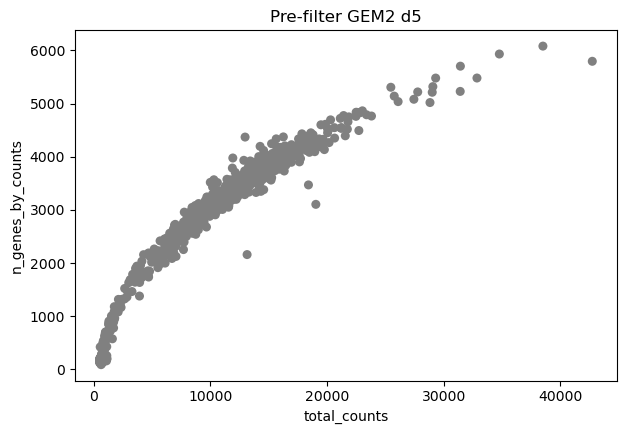

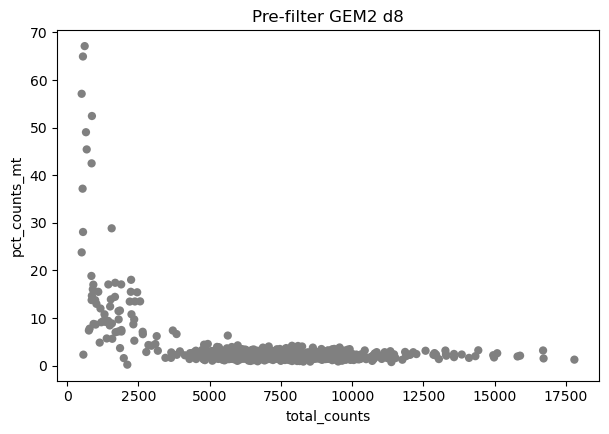

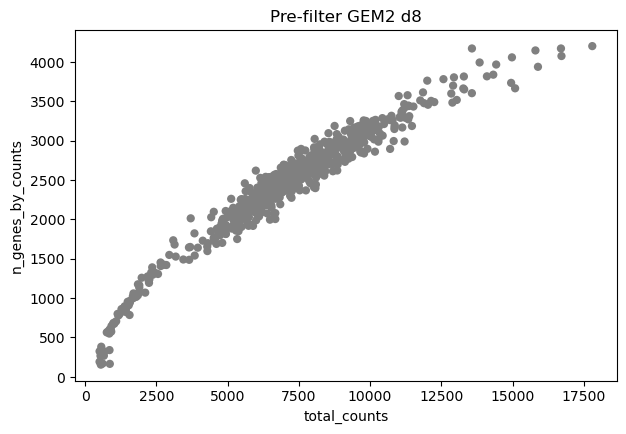

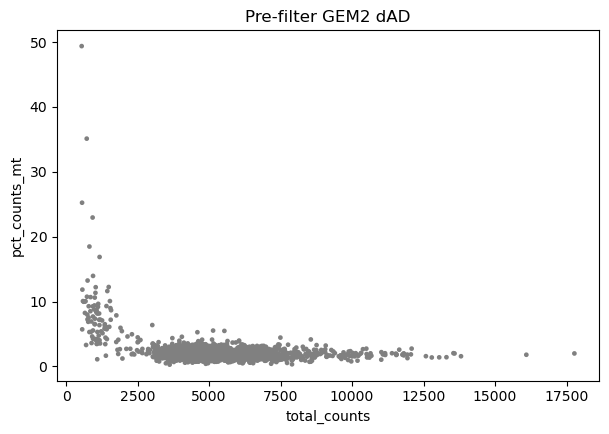

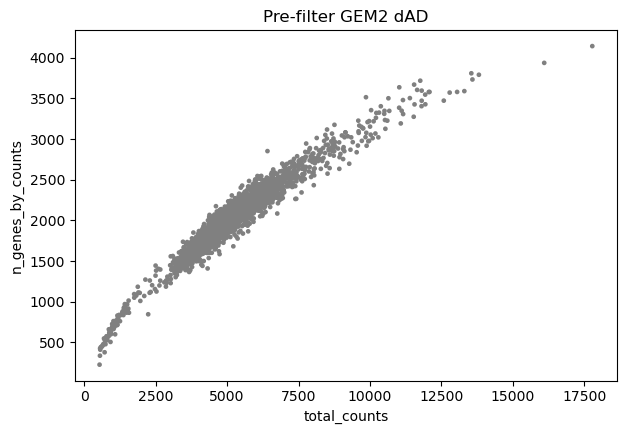

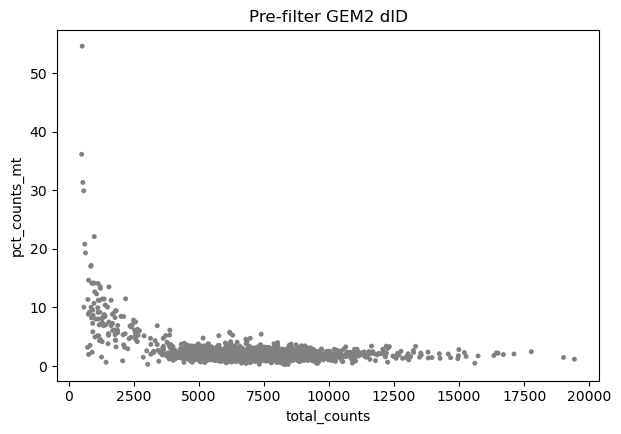

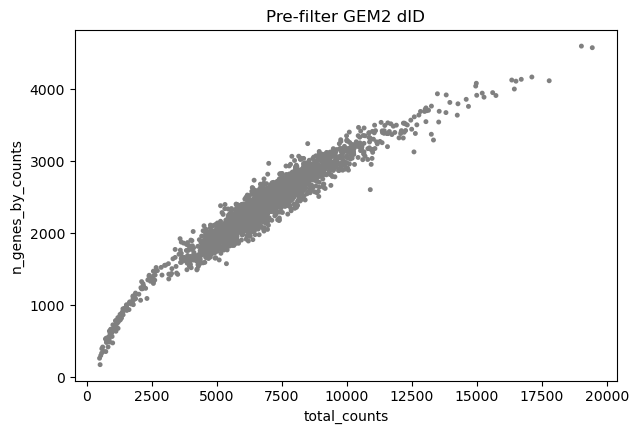

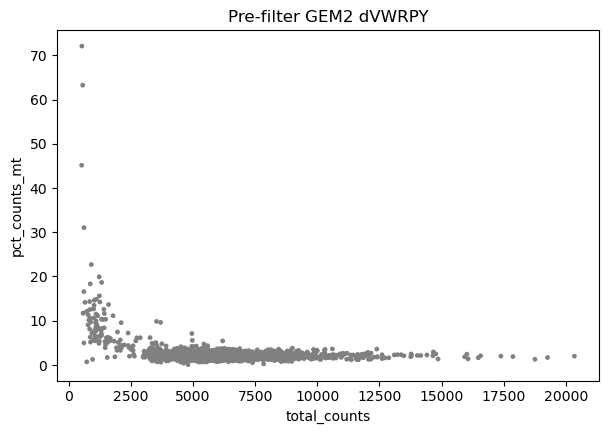

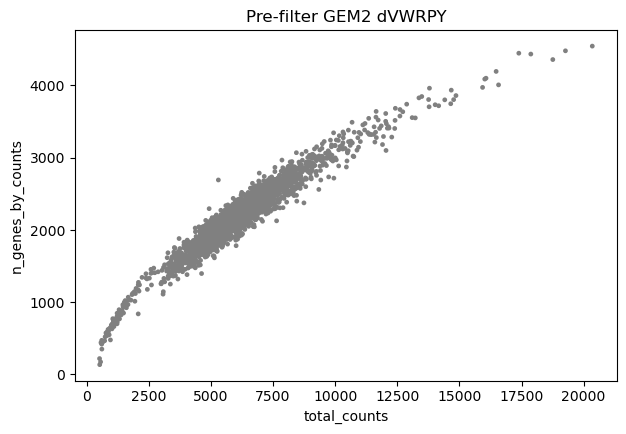

In [11]:
# adata2
# Mitochondrial genes
adata2.var["mt"] = adata2.var_names.str.startswith("mt-")
# Ribosomal genes
adata2.var["ribo"] = adata2.var_names.str.startswith(("Rps", "Rpl"))

# Calculate percent mitochondrial gene contamination
sc.pp.calculate_qc_metrics(adata2, qc_vars=['mt', 'ribo'], percent_top=None, log1p=True, inplace=True,)

# Plot quality metrics:

sc.pl.violin(adata2, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby= "group", jitter=0.4, multi_panel=True)
for group in sample_names:
    
    sc.pl.scatter(adata2[adata2.obs.group == group, :], x='total_counts', y='pct_counts_mt', title = "Pre-filter GEM2 "+group)
    sc.pl.scatter(adata2[adata2.obs.group == group, :], x='total_counts', y='n_genes_by_counts', title = "Pre-filter GEM2 "+group)
# End of loop

del(group) # Cleanup

Now for each sample in the array "samples" do the following:

1) Correct for ambient RNA.
2) Do doublet discrimination with scrublet and scDblFinder and mark doublets, but do not filter yet!
3) Create low-level filters.
4) High-level filtering:
 - remove cells with less than 200 genes
 - genes expressed in less than 3 cells
 - genes with less than 5 counts
5) Do low level filtering by removing high MT contamination, doublets and low counts.

### Ambient RNA correction on GEM1

First import packages to run R on the notebook:

In [12]:
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

SoupX requires basic clustering data and raw data, so do that:

In [13]:
# Make adata copy then normalize
adata_pp = adata1.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

# Do dimensionality reduction
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Extract groups
soupx_groups = adata_pp.obs["soupx_groups"]

# Cleanup, remove extra adata
del adata_pp

# Prepare data for SoupX
cells = adata1.obs_names
genes = adata1.var_names
data = adata1.X.T

# Import raw data needed for SoupX
adata_raw = sc.read_10x_h5(filename="../../source_data/gem1/outs/multi/count/raw_feature_bc_matrix.h5")
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T
del adata_raw

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:30)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
running Leiden clustering
    finished: found 16 clusters and added
    'soupx_groups', the cluster labels (adata.obs, categorical) (0:00:03)
reading ../../source_data/gem1/outs/multi/count/raw_feature_bc_matrix.h5
 (0:00:04)


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Call the R function:

In [14]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 
library(SoupX)

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SboupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Take the outputs from R and reassign to adata:

In [15]:
adata1.layers["counts"] = adata1.X
adata1.layers["soupX_counts"] = out.T
adata1.X = adata1.layers["soupX_counts"]

# Cleanup
del(out, data, data_tod, genes, cells, soupx_groups)

### Ambient RNA correction on GEM2

First import packages to run R on the notebook:

In [16]:
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


SoupX requires basic clustering data and raw data, so do that:

In [17]:
# Make adata copy then normalize
adata_pp = adata2.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

# Do dimensionality reduction
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Extract groups
soupx_groups = adata_pp.obs["soupx_groups"]

# Cleanup, remove extra adata
del adata_pp

# Prepare data for SoupX
cells = adata2.obs_names
genes = adata2.var_names
data = adata2.X.T

# Import raw data needed for SoupX
adata_raw = sc.read_10x_h5(filename="../../source_data/gem2/outs/multi/count/raw_feature_bc_matrix.h5")
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T
del adata_raw

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:29)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 15 clusters and added
    'soupx_groups', the cluster labels (adata.obs, categorical) (0:00:04)
reading ../../source_data/gem2/outs/multi/count/raw_feature_bc_matrix.h5
 (0:00:06)


/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Call the R function:

In [18]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 
library(SoupX)

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
data <- as(data, "sparseMatrix")
data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SboupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

Take the outputs from R and reassign to adata:

In [19]:
adata2.layers["counts"] = adata2.X
adata2.layers["soupX_counts"] = out.T
adata2.X = adata2.layers["soupX_counts"]

# Cleanup
del(out, data, data_tod, genes, cells, soupx_groups)

### Doublet Discrimination

Analyze using scrublet and scDblFinder:

Running Scrublet
filtered out 14159 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Detected doublet rate = 3.7%
Estimated detectable doublet fraction = 36.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 9.9%
    Scrublet finished (0:00:34)


/opt/conda/lib/python3.10/site-packages/scanpy/external/pl.py:419: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for idx, (batch_key, sub_obs) in enumerate(adata.obs.groupby(batches)):


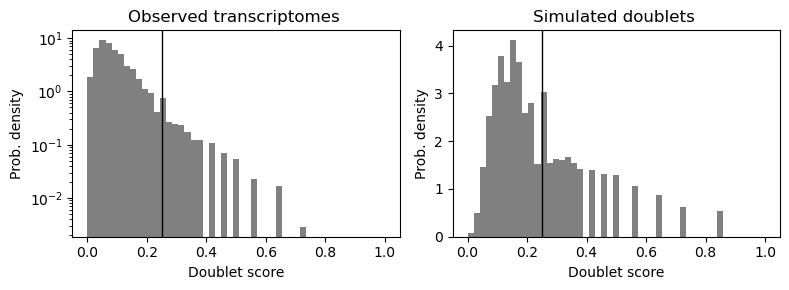

In [20]:
# Doublet discrimination with scrublet
sce.pp.scrublet(
    adata1,
    adata_sim = None,
    threshold=0.25,
)
%matplotlib inline
sce.pl.scrublet_score_distribution(adata1)

Running Scrublet
filtered out 14097 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Detected doublet rate = 4.0%
Estimated detectable doublet fraction = 38.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 10.3%
    Scrublet finished (0:00:31)


/opt/conda/lib/python3.10/site-packages/scanpy/external/pl.py:419: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for idx, (batch_key, sub_obs) in enumerate(adata.obs.groupby(batches)):


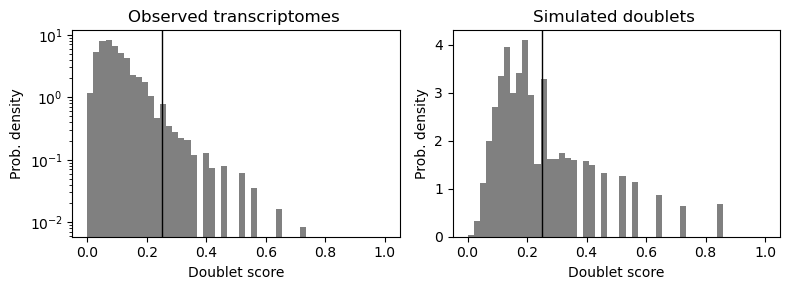

In [21]:
# Doublet discrimination with scrublet
sce.pp.scrublet(
    adata2,
    adata_sim = None,
    threshold=0.25,
)
sce.pl.scrublet_score_distribution(adata2)

Do another doublet discrimination technique using scDblDinder:

In [22]:
# Doublet discrimination by scDblFinder
# First extract matrix:
data_mat = adata1.X.T

Import R functions to score doublets:

In [23]:
%%R -i data_mat -o doublet_score -o doublet_class

library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)


set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

In [24]:
# Reassign scDblFinder scores into data:
adata1.obs["scDblFinder_score"] = doublet_score
adata1.obs["scDblFinder_class"] = doublet_class
adata1.obs.scDblFinder_class.value_counts()

del(doublet_score, doublet_class, data_mat)

In [25]:
# Doublet discrimination by scDblFinder
# First extract matrix:
data_mat = adata2.X.T

Import R functions to score doublets:

In [26]:
%%R -i data_mat -o doublet_score -o doublet_class

library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)


set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

In [27]:
# Reassign scDblFinder scores into data:
adata2.obs["scDblFinder_score"] = doublet_score
adata2.obs["scDblFinder_class"] = doublet_class
adata2.obs.scDblFinder_class.value_counts()

del(doublet_score, doublet_class, data_mat)

In [28]:
# Restore Plotting
%matplotlib inline

### Combine adata1 and adata2

In [29]:
# adata1 and adata2 are from two GEMs, merge them together
adata = sc.AnnData.concatenate(adata1, adata2, join = "outer", batch_key="gem", batch_categories=["gem1", "gem2"], index_unique="-")
print(adata)
del(adata1, adata2)

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1823: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 35129 × 32285
    obs: 'experiment', 'group', 'timepoint', 'infection', 'cell_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_score', 'predicted_doublet', 'scDblFinder_score', 'scDblFinder_class', 'gem'
    var: 'mt', 'ribo', 'n_cells_by_counts-gem1', 'mean_counts-gem1', 'log1p_mean_counts-gem1', 'pct_dropout_by_counts-gem1', 'total_counts-gem1', 'log1p_total_counts-gem1', 'n_cells_by_counts-gem2', 'mean_counts-gem2', 'log1p_mean_counts-gem2', 'pct_dropout_by_counts-gem2', 'total_counts-gem2', 'log1p_total_counts-gem2'
    layers: 'counts', 'soupX_counts'


### Create low-level filters

In [30]:
# Create Filters
conditions = [
    (adata.obs['predicted_doublet'] == True),
    (adata.obs['scDblFinder_class'] == "doublet"),
    (adata.obs['n_genes_by_counts'] < 1250),
    (adata.obs['total_counts'] < 3000),
    (adata.obs['pct_counts_mt'] > 5),
    (adata.obs['pct_counts_mt'] <= 5) & (adata.obs['n_genes_by_counts'] >= 1250) & (adata.obs['total_counts'] >= 3000) & (adata.obs['scDblFinder_class'] == "singlet") & (adata.obs['predicted_doublet'] == False)]

values = [ 
            'Doublet_Scrublet', 
            'Doublet_scDblFinder', 
            'Low_nFeature', 
            'Low_counts', 
            'High_MT', 
            'Pass']
adata.obs['QC'] = np.select(conditions, values)
adata.obs['QC'] = adata.obs['QC'].astype('category')

# Filters
adata.obs['QC'].value_counts()

QC
Pass                   28409
Doublet_scDblFinder     2850
Low_nFeature            2023
Doublet_Scrublet        1343
Low_counts               360
High_MT                  144
Name: count, dtype: int64

### Filter

In [31]:
# High level filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_genes(adata, min_counts=5)

# Filtering
adata = adata[adata.obs['QC'] == 'Pass', :]

filtered out 113 cells that have less than 200 genes expressed
filtered out 12588 genes that are detected in less than 3 cells
filtered out 1236 genes that are detected in less than 5 counts


## Post-Filtering

Check sample names:

In [32]:
# Check if sample labeling carried over
print(adata)
print(adata.obs['group'].value_counts())

View of AnnData object with n_obs × n_vars = 28409 × 18461
    obs: 'experiment', 'group', 'timepoint', 'infection', 'cell_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_score', 'predicted_doublet', 'scDblFinder_score', 'scDblFinder_class', 'gem', 'QC', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts-gem1', 'mean_counts-gem1', 'log1p_mean_counts-gem1', 'pct_dropout_by_counts-gem1', 'total_counts-gem1', 'log1p_total_counts-gem1', 'n_cells_by_counts-gem2', 'mean_counts-gem2', 'log1p_mean_counts-gem2', 'pct_dropout_by_counts-gem2', 'total_counts-gem2', 'log1p_total_counts-gem2', 'n_cells', 'n_counts'
    layers: 'counts', 'soupX_counts'
group
WT        4828
Null      4585
dAD       4304
Base      4202
dID       4050
dVWRPY    3701
d8        1218
d5         977
Naive      544
Name: count, dtype: int64


Check the resulting quality metrics of the combined samples:

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/opt/conda/lib/python3.10/site-packages

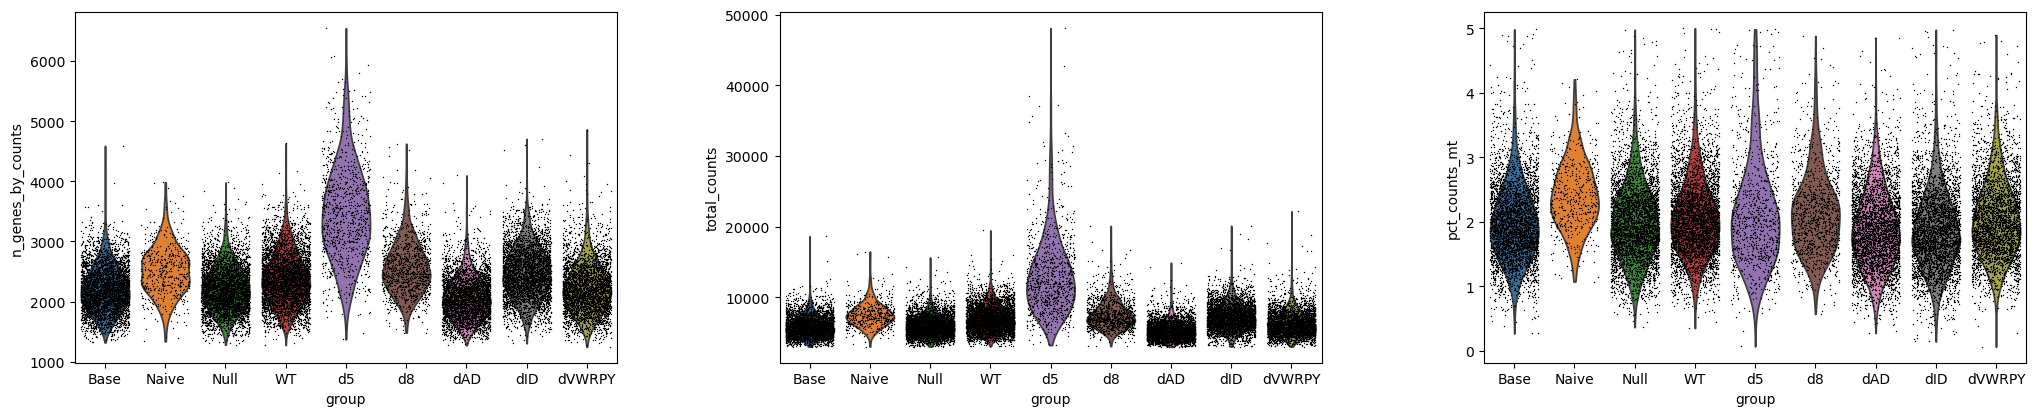

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:315: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


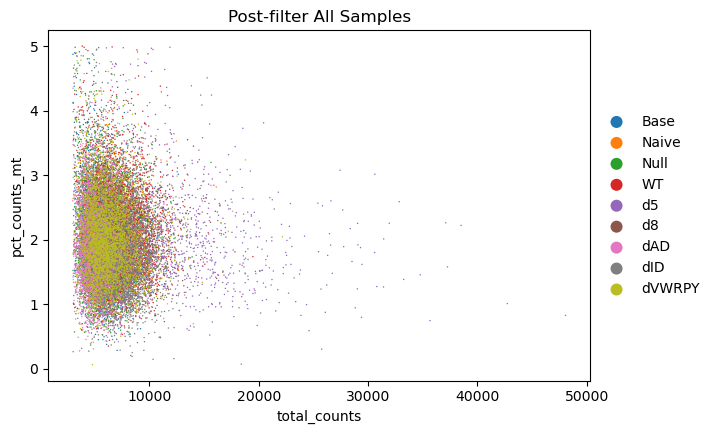

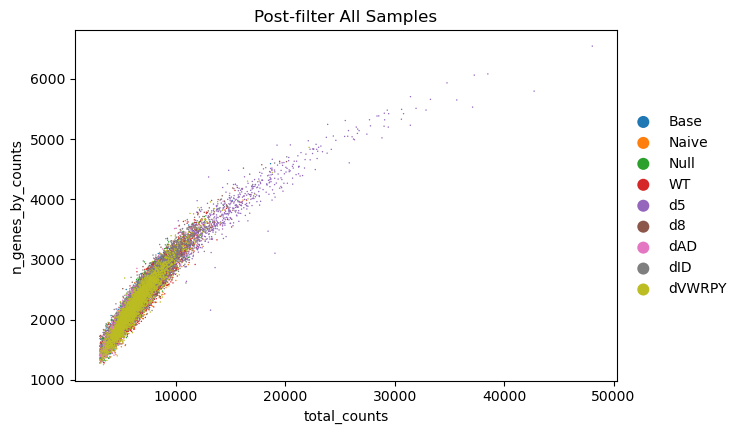

In [33]:
# Plot combined QC metrics, grouped by sample (singlet filtered)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby= "group", jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color = "group", title = "Post-filter All Samples")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color = "group", title = "Post-filter All Samples")

normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


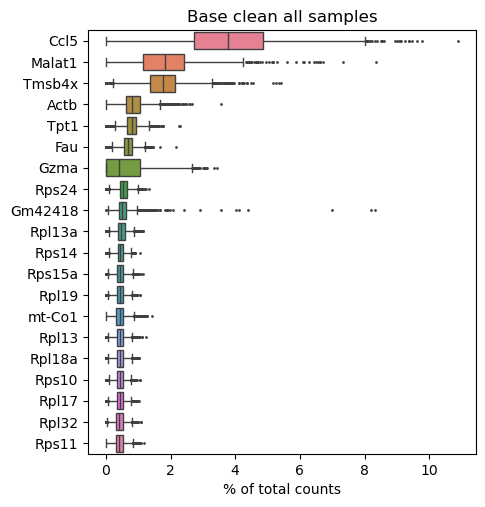

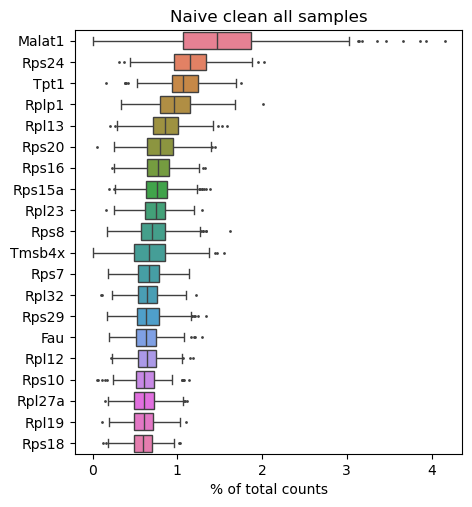

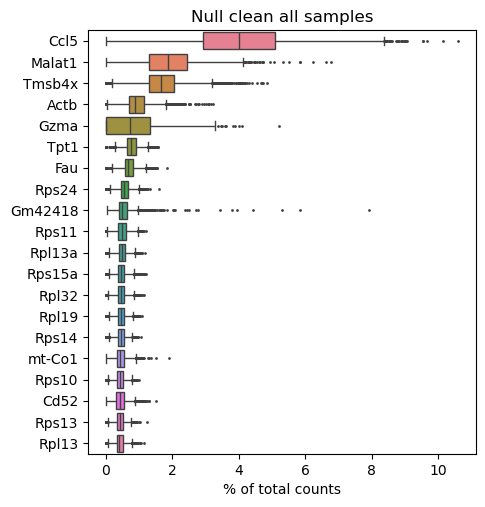

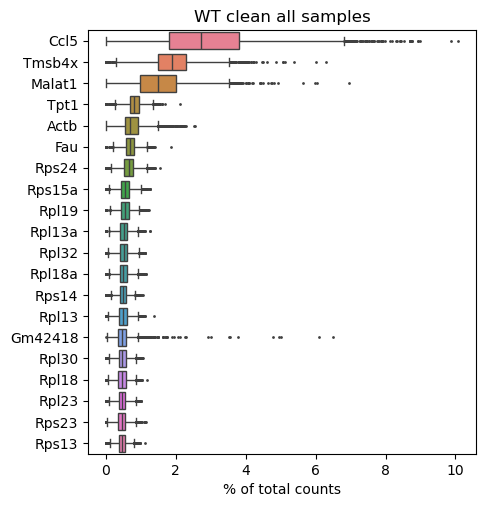

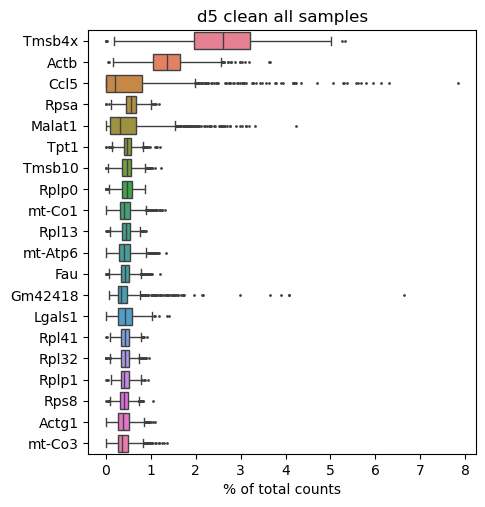

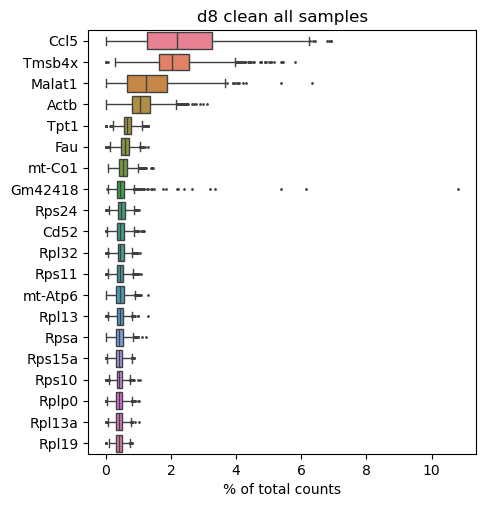

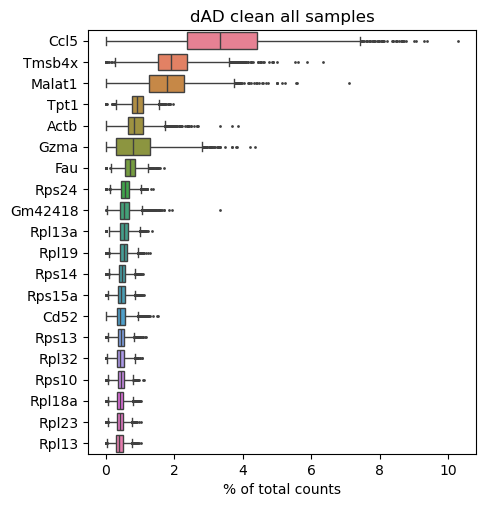

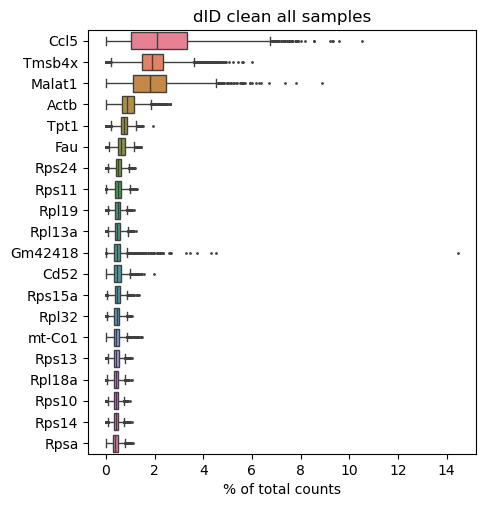

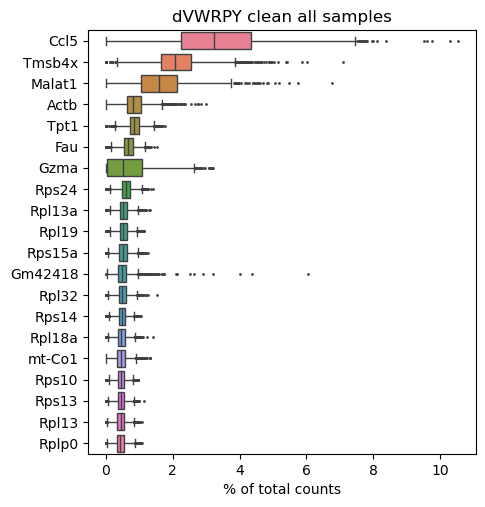

In [34]:
# Plot highest expressed genes per sample
for group in sample_names:
    plot = sc.pl.highest_expr_genes(adata[adata.obs.group == group, :], n_top=20, show = False)
    plot.set_title(group + " clean all samples")
# End of loop

del(plot) # Cleanup

## Cell Cycle Regression

These steps socre cell cycle effects and regress these effects out.

In [35]:
# Load S genes
s_genes =  [x.strip() for x in open('../../source_data/mouse-s-gene-list.csv')]
print(s_genes)

# Load G2M genes
g2m_genes =  [x.strip() for x in open('../../source_data/mouse-g2m-gene-list.csv')]
print(g2m_genes)

# Score cells for cell cycle
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes) # Score filtered adata

['Rrm2', 'Mcm4', 'Gmnn', 'Exo1', 'Mrpl36', 'Uhrf1', 'Chaf1b', 'Cdc45', 'Msh2', 'Cdc6', 'Slbp', 'Rad51ap1', 'Cenpu', 'Ubr7', 'Dscc1', 'Hells', 'Fen1', 'Prim1', 'Mcm6', 'Wdr76', 'Ung', 'Mcm5', 'Blm', 'Pola1', 'Clspn', 'Usp1', 'Tipin', 'Gins2', 'Nasp', 'Dtl', 'Cdca7', 'Tyms', 'Pcna', 'Rfc2', 'Polr1b', 'Casp8ap2', 'Rrm1', 'Rad51', 'Ccne2', 'Mcm7', 'E2f8']
['Cbx5', 'Cdc25c', 'Dlgap5', 'Gtse1', 'Smc4', 'Ctcf', 'Kif20b', 'Cdca2', 'Top2a', 'Hmgb2', 'Cdk1', 'Ncapd2', 'G2e3', 'Ttk', 'Tacc3', 'Ckap2', 'Cks2', 'Gas2l3', 'Cdca3', 'Anp32e', 'Kif2c', 'Ccnb2', 'Kif23', 'Anln', 'Psrc1', 'Ect2', 'Hmmr', 'Tpx2', 'Aurkb', 'Cdca8', 'Kif11', 'Cdc20', 'Rangap1', 'Cks1b', 'Cenpf', 'Hjurp', 'Cenpe', 'Lbr', 'Birc5', 'Ndc80', 'Nek2', 'Cenpa', 'Aurka', 'Jpt1', 'Nuf2', 'Ube2c', 'Tubb4b', 'Ckap2l', 'Pimreg', 'Mki67', 'Ckap5', 'Bub1', 'Nusap1']
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    490 total control genes are used. (0:00:01)
compu

## Normalization

Steps from here and onwards describe normalization steps prior to clustering analyses.

The first step is to normalize cell counts to 20,000 reads per cell. We choose this number based on the Day 5 sample distribution.

In [36]:
# Normalize read counts
sc.pp.normalize_total(adata, target_sum=2e4) # cell filtered

normalizing counts per cell
    finished (0:00:00)


Then logarithmize the data:

In [37]:
# Change to logarithmic scale
sc.pp.log1p(adata) # cell filtered

Stratify between MRE (adata) and RPE.

Then identify highly-variable genes and plot:

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
extracting highly variable genes


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


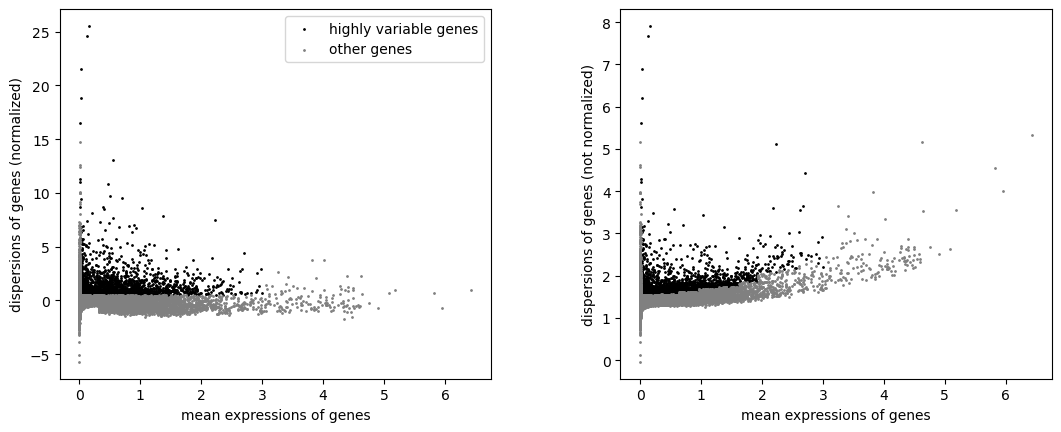

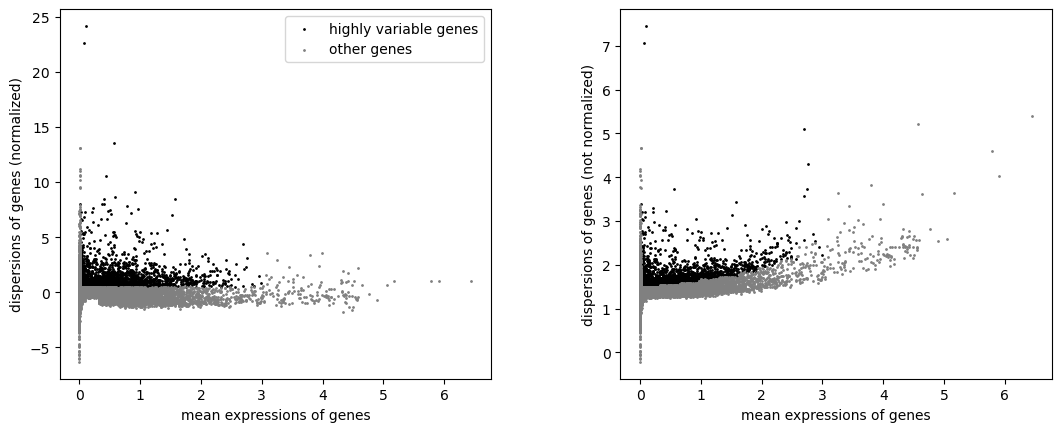

In [38]:
# Keep only rescue data
RPE   = adata[ (adata.obs.group != "dAD") & 
               (adata.obs.group != "dID") &
               (adata.obs.group != "dVWRPY")].copy()

# Identify variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(RPE, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Plot variable genes
sc.pl.highly_variable_genes(adata)
sc.pl.highly_variable_genes(RPE)

Set the raw attribute of AnnData as the normalized values, which is done prior to regression of count effects. This allows recovery of raw normalized data prior to correction:

In [39]:
# Store raw data
adata.raw = adata
RPE.raw = RPE

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance. In this step, I skipped filtering by highly variable genes that is present in the Scanpy tutorial, as I am interested in all genes.

In [40]:
# Regress out the effects of cell count and mitochondrial contamination
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score'])
sc.pp.regress_out(RPE, ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score'])
# Lastly, scale the data
sc.pp.scale(adata)
sc.pp.scale(RPE)
# Check the resulting AnnData object
print("MRE:")
print(adata)
print("RPE:")
print(RPE)

regressing out ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score']
    sparse input is densified and may lead to high memory use


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:619: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if keys[0] in adata.obs_keys() and is_categorical_dtype(adata.obs[keys[0]]):


    finished (0:06:40)
regressing out ['total_counts', 'pct_counts_mt', 'S_score', 'G2M_score']
    sparse input is densified and may lead to high memory use


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:619: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if keys[0] in adata.obs_keys() and is_categorical_dtype(adata.obs[keys[0]]):


    finished (0:04:17)
MRE:
AnnData object with n_obs × n_vars = 28409 × 18461
    obs: 'experiment', 'group', 'timepoint', 'infection', 'cell_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_score', 'predicted_doublet', 'scDblFinder_score', 'scDblFinder_class', 'gem', 'QC', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'mt', 'ribo', 'n_cells_by_counts-gem1', 'mean_counts-gem1', 'log1p_mean_counts-gem1', 'pct_dropout_by_counts-gem1', 'total_counts-gem1', 'log1p_total_counts-gem1', 'n_cells_by_counts-gem2', 'mean_counts-gem2', 'log1p_mean_counts-gem2', 'pct_dropout_by_counts-gem2', 'total_counts-gem2', 'log1p_total_counts-gem2', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'group_colors', 'log1p', 'hvg'
    layers: 'counts', 'soupX_counts'
RP

## Principal Component Analysis

We can now do the preliminary steps prior to clustering analyses since the data is normalized and regressed. Start by identifying principal components:

In [41]:
# Compute principal components
sc.tl.pca(adata, svd_solver='arpack', n_comps = 75)
sc.tl.pca(RPE, svd_solver='arpack', n_comps = 75)

computing PCA
    on highly variable genes
    with n_comps=75
    finished (0:00:34)
computing PCA
    on highly variable genes
    with n_comps=75
    finished (0:00:24)


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

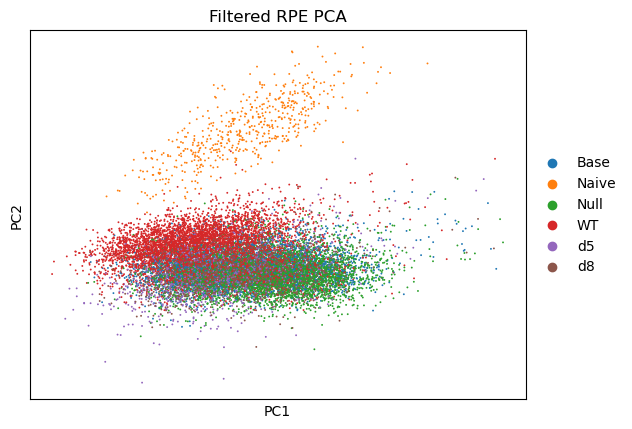

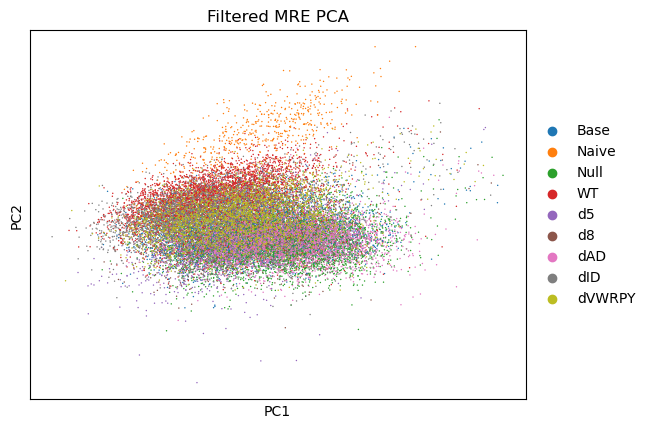

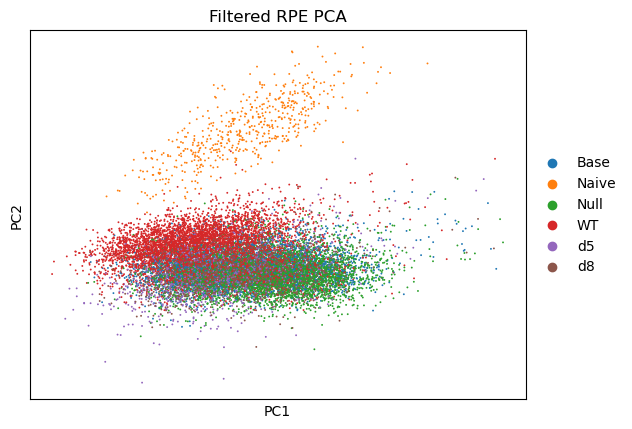

In [42]:
# Plot
sc.pl.pca(adata, color='group', return_fig = True, title = "Filtered MRE PCA")
sc.pl.pca(RPE, color='group', return_fig = True, title = "Filtered RPE PCA")

Identify the contribution of each principal component to variance through a Scree plot:

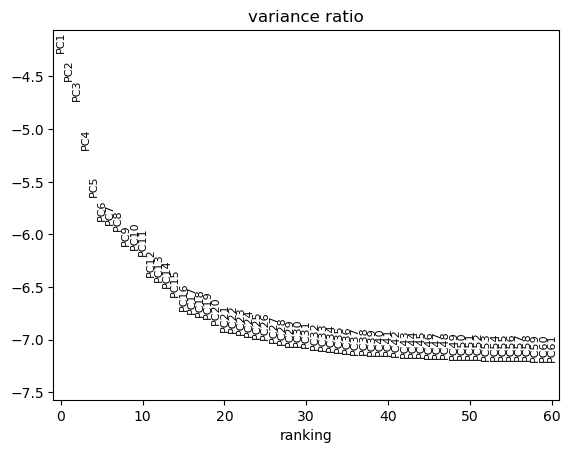

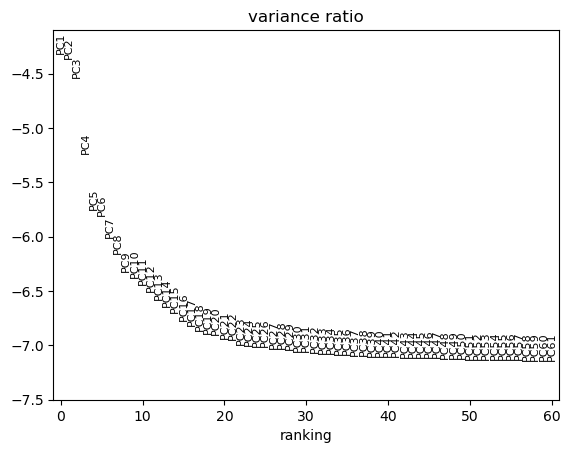

In [43]:
# Plot the Scree plot:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 60)
sc.pl.pca_variance_ratio(RPE, log=True, n_pcs = 60)

## Save Data
Procedures for saving data are outlined below:

In [44]:
# Reminder for the saved data
if savedata:

    print("The AnnData outputs of this notebook will be saved in the h5ad/ folder.")

    # Save data to an AnnData file
    print("MRE:" + fn + sf + "_MRE.h5ad")
    adata.write_h5ad(filename = "../../h5ad/" + fn + sf + "_MRE.h5ad", compression = "gzip", compression_opts = 9)
    print(adata)
    print("RPE:" + fn + sf + "_RPE.h5ad")
    RPE.write_h5ad(filename = "../../h5ad/" + fn + sf + "_RPE.h5ad", compression = "gzip", compression_opts = 9)
    print(RPE)

else:

    print("Not saving the AnnData file!")
    
# End of Notebook
print("\nNotebook Ends")

The AnnData outputs of this notebook will be saved in the h5ad/ folder.
MRE:01_25-12-05-19-13_preprocessing_MRE.h5ad
AnnData object with n_obs × n_vars = 28409 × 18461
    obs: 'experiment', 'group', 'timepoint', 'infection', 'cell_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_score', 'predicted_doublet', 'scDblFinder_score', 'scDblFinder_class', 'gem', 'QC', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'mt', 'ribo', 'n_cells_by_counts-gem1', 'mean_counts-gem1', 'log1p_mean_counts-gem1', 'pct_dropout_by_counts-gem1', 'total_counts-gem1', 'log1p_total_counts-gem1', 'n_cells_by_counts-gem2', 'mean_counts-gem2', 'log1p_mean_counts-gem2', 'pct_dropout_by_counts-gem2', 'total_counts-gem2', 'log1p_total_counts-gem2', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mea